In [3]:
import sys

sys.path.append("kalmannet")
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
%matplotlib widget

In [4]:
pipeline = torch.load("models\pipeline_KNet_Linear_Neural")

In [5]:
X_test = scio.loadmat("data/X_test.mat")
Y_test = scio.loadmat("data/Y_test.mat")
X_train = scio.loadmat("data/X_train.mat")
Y_train = scio.loadmat("data/Y_train.mat")
X_val = scio.loadmat("data/X_val.mat")
Y_val = scio.loadmat("data/Y_val.mat")
X_test = torch.tensor(X_test["X_test"]).t().float()
Y_test = torch.tensor(Y_test["Y_test"]).t().float()
X_train = torch.tensor(X_train["X_train"]).t().float()
Y_train = torch.tensor(Y_train["Y_train"]).t().float()
X_val = torch.tensor(X_val["X_val"]).t().float()
Y_val = torch.tensor(Y_val["Y_val"]).t().float()

Text(0.5, 0, 'Epoch')

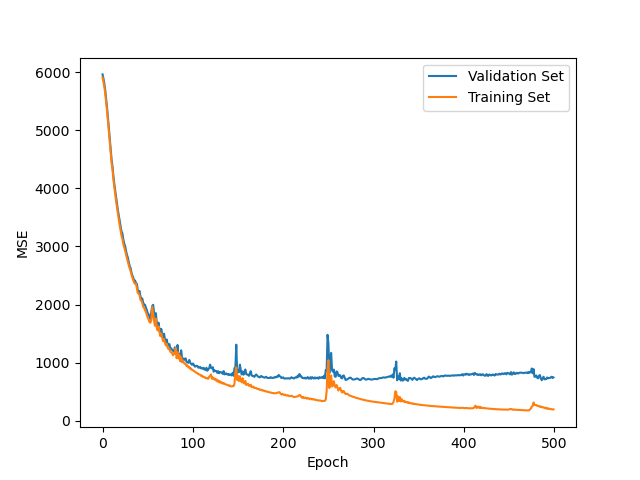

In [6]:
# Training and Validation MSE across training
plt.figure()
plt.plot(np.power(10, pipeline.MSE_cv_dB_epoch.cpu()/10))
plt.plot(np.power(10, pipeline.MSE_train_dB_epoch.cpu()/10))
plt.legend(["Validation Set", "Training Set"])
plt.ylabel("MSE")
plt.xlabel("Epoch")

In [7]:
# Show reconstruction of training
pipeline.MSE_test_linear_arr
x_out_test = torch.empty(pipeline.ssModel.m, pipeline.ssModel.T_test)
for t in range(0, pipeline.ssModel.T_test):
    x_out_test[:, t] = pipeline.model(Y_test[:, t])

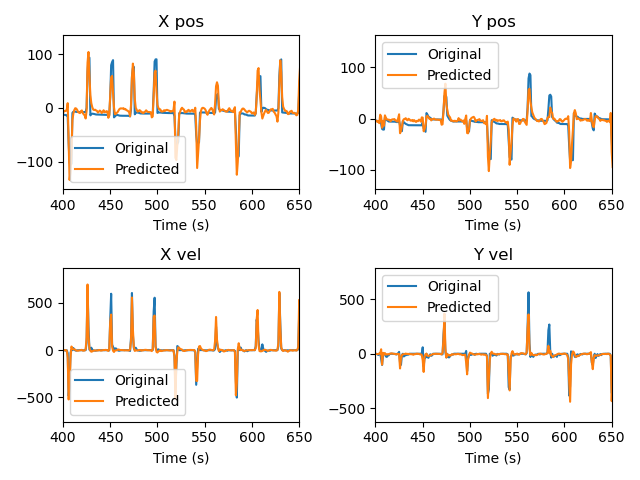

In [8]:
fig = plt.figure()
titles = ["X pos", "Y pos", "X vel","Y vel"]
for i in range(4):
    plt.subplot(221+i)
    plt.plot(X_test[i,:].detach().cpu().numpy())
    plt.plot(x_out_test[i,:].detach().cpu().numpy())
    plt.legend(["Original","Predicted"])
    plt.xlabel("Time (s)")
    plt.xlim(400, 650)
    plt.title(titles[i])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


In [9]:
corr = np.zeros(4)
for i in range(4):
    corr[i] = np.corrcoef(x_out_test[i, :].detach().cpu(), X_test[i, :].cpu())[0, 1]
mse_x = np.square(np.subtract(x_out_test.detach().cpu(), X_test.cpu())).mean(1)

In [10]:
corr, mse_x

(array([0.90499626, 0.88081048, 0.94866333, 0.9363075 ]),
 tensor([ 153.7061,  141.9385, 1262.3323, 1206.4381], device='cpu'))